# Life 101

In this notebook, we create a simple analogy between Wikispeedia game and "Life". We found out that some advices given in the game are also applicable in real life and we can learn from them! 

# Data Preparation

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import src.utils as utils

# import src.LLM as LLM

# Automatically reload the module in case of changes
%load_ext autoreload
%autoreload 2

In [8]:
data_path = "./data/wikispeedia_paths-and-graph/"

# Load finished paths
finished_paths = utils.load_dataframe(data_path + "paths_finished.tsv", skip_rows=16, columns=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])

# Load unfinished paths
unfinished_paths = utils.load_dataframe(data_path + "paths_unfinished.tsv", skip_rows=16, columns=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"])

# Load categories
categories = utils.load_dataframe(data_path + "categories.tsv", skip_rows=12, columns=["page", "category"])

# Load links
links_df = utils.load_dataframe(data_path + "links.tsv", skip_rows=12, columns=["source", "target"])

In [9]:
# Data cleaning and preprocessing
categories_dict = utils.manage_categories(categories.copy())
finished_paths_df = utils.manage_paths(finished_paths.copy(), categories_dict.copy())
unfinished_paths_df = utils.manage_paths(unfinished_paths.copy(), categories_dict.copy())
links_dict = utils.manage_links(links_df.copy())

graph = utils.create_graph(links_df.copy())
ranks = utils.page_rank(graph)

# Save the cleaned dataframes
finished_paths_df.to_csv("./data/clean_finished_paths.csv")
unfinished_paths_df.to_csv("./data/clean_unfinished_paths.csv")

/Users/yasmine/Documents/00-Master_EPFL/MA3/ADA/ada-2024-project-tadaa/src/utils.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  paths_df["rating"].fillna(-1, inplace=True)


# Don't trust LLMs blindly! (Not you Copilot, you know I love you)

We will compare people performance to LLM performance by considering the most taken paths by people and launching them on a 4bit quantized version of Qwen-3b. A fairly small LLM that could run on our machines/Colab in a reasonable time. We run the same task from source to target 100 times using the LLM. This allows us to have statistically relevant paths especially that the LLM is sometimes lost and not able to finish the paths everytime.

## Prompting strategy
In order to get the model to work, we did prompt engineering trying multiple instructionns for the model. A detailed explanation is available in the read me. The overall idea of the prompt is that we give the model only the target and the list of possible links at a certain step and we ask it about the best choice in order to get closer to the target. If the answer is not in the list, we keep the context of the conversation and we tell the model that it gave us an article not in the list and we ask it to correct itself. If it does, then we continue, otherwise, the path is considered aborted.
If we have an answer, we restart with a completely new context using a similar prompt.

## Comparison strategy
As we get multiple samples of answers (100 in our case) from the LLM for each source-target pair, we get an estimate of the distribution of lengths of the paths given by the LLM. Similarly, we have multiple samples of player paths, so we can not only compare the means of the path lengths but also do a t-test similarity test to know if the distributions are similar or not.

In [ ]:
# Group the finished paths DataFrame by "source" and "target" columns, then count occurrences in each group
top_paths = finished_paths_df.groupby(["source", "target"]).count()

# Sort the grouped data by the "hashedIpAddress" column in descending order to get the most frequent paths
top_paths = top_paths.sort_values(by="hashedIpAddress", ascending=False).reset_index()

# Rename the "hashedIpAddress" column to "count" and select the top 10 most frequent paths
top_paths = top_paths.rename(columns={"hashedIpAddress": "count"}).head(10)

# Extract the "source" column values of the top paths as a list
sources = top_paths['source'].tolist()

# Extract the "target" column values of the top paths as a list
targets = top_paths['target'].tolist()

# Get the LLM paths
# paths = LLM.llm_paths(sources, targets, links_dict)
llm_paths = utils.read_llm_paths("./data/llm_paths.json")

                                 source                   target  \
0                              Asteroid                   Viking   
1                                 Brain                Telephone   
2                               Theatre                    Zebra   
3                               Pyramid                     Bean   
4                                Batman                     Wood   
...                                 ...                      ...   
28696                   Great_Cormorant  Eastern_Orthodox_Church   
28697               Great_Comet_of_1882                  Skylark   
28698               Great_Comet_of_1882             Principality   
28699                  John_Logie_Baird              Trade_union   
28700  Tropical_Storm_Bonnie_%282004%29                  Rhodium   

       hashedIpAddress  timestamp  durationInSec  path  rating  \
0                 1043       1043           1043  1043    1043   
1                 1040       1040           1040  1

FileNotFoundError: [Errno 2] No such file or directory: './data/llm_paths.json'

In [84]:

def plot_llms_vs_players():
    llm_means = []
    llm_std_errors = []
    player_means = []
    player_std_errors = []

    for source, target in zip(sources, targets):
        player_paths = finished_paths_df[(finished_paths_df["source"] == source) & (finished_paths_df["target"] == target)]
        player_mean_length = player_paths["path_length"].mean()
        player_std_error = player_paths["path_length"].sem()
        player_std_errors.append(player_std_error)
        player_means.append(player_mean_length)
        
        llm_source_target = llm_paths[source+"_"+target]
        llm_mean_length = 0
        for path in llm_source_target:
            llm_mean_length += len(path)
        llm_mean_length /= len(llm_source_target)
        llm_std_error = 0
        for path in llm_source_target:
            llm_std_error += (len(path) - llm_mean_length)**2
        llm_std_error /= len(llm_source_target)
        llm_std_error = llm_std_error**0.5
        llm_means.append(llm_mean_length)
        llm_std_errors.append(llm_std_error)
    fig, ax = plt.subplots()
    ax.errorbar(range(10), player_means, yerr=player_std_errors, fmt="o", label="Player Paths")
    ax.errorbar(range(10), llm_means, yerr=llm_std_errors, fmt="o", label="LLM Paths")
    ax.set_xticks(range(10))
    ax.set_xticklabels([f"{source} -> {target}" for source, target in zip(sources, targets)], rotation=90)  
    ax.set_ylabel("Path Length")
    ax.set_xlabel("Source -> Target")
    plt.title("Player Paths vs LLM mean path length per source-target pair")
    ax.legend()
    plt.show()


def tstats_pvalues():
    t_stats = []
    p_values = []
    t_critical = []
    for source, target in zip(sources, targets):
        player_paths = finished_paths_df[(finished_paths_df["source"] == source) & (finished_paths_df["target"] == target)]
        llm_source_target = llm_paths[source+"_"+target]
        t_stat, p_value = stats.ttest_ind(player_paths["path_length"], [len(path) for path in llm_source_target])
        t_stats.append(abs(t_stat))
        p_values.append(p_value)  
        t_critical.append(stats.t.ppf(1-0.05/2, len(player_paths["path_length"]) + len(llm_source_target) - 2))
    return t_stats, p_values, t_critical

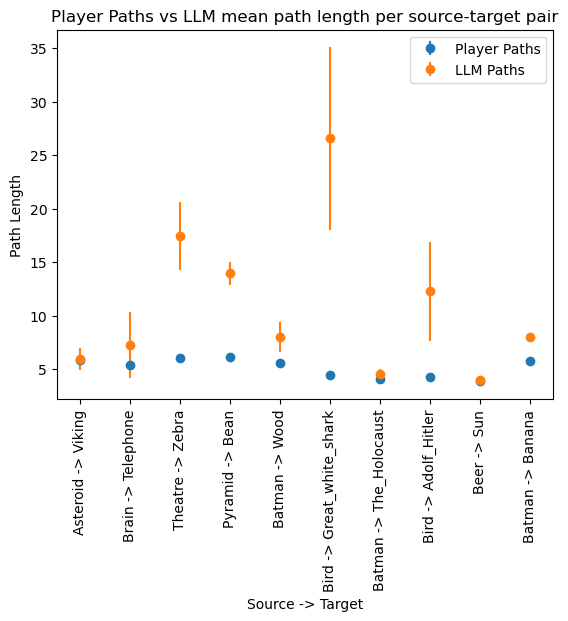

c:\Users\hasse\anaconda3\envs\ada\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


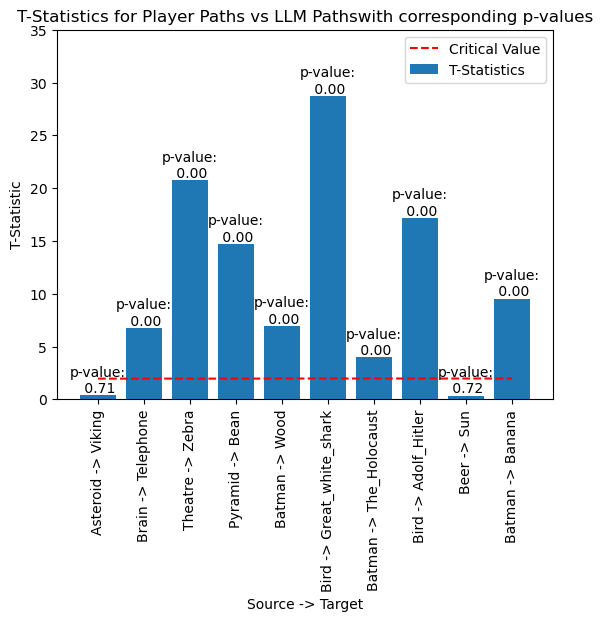

In [ ]:
plot_llms_vs_players()       
t_stats, p_values, t_critical = tstats_pvalues()
fig, ax = plt.subplots()
ax.bar(range(10), t_stats, label='T-Statistics')
ax.plot(range(10), t_critical, label='Critical Value', linestyle='--', color='red')
# write p-values on top of the bars
for i, p_value in enumerate(p_values):
    ax.text(i, t_stats[i], f"p-value:\n {p_value:.2f}", ha='center', va='bottom')
    
ax.set_xticks(range(10))
ax.set_xticklabels([f"{source} -> {target}" for source, target in zip(sources, targets)], rotation=90)
ax.set_ylabel("T-Statistic")
ax.set_xlabel("Source -> Target")
ax.set_ylim(0, 35)
plt.title("T-Statistics for Player Paths vs LLM Pathswith corresponding p-values")
ax.legend()
plt.show()

The first plot shows that the LLM's performance is worse in about all the source-target pairs. However, we are not confident that it's better in all of them. (for example, the players mean falls into the standard error of the LLM mean for the Brain-Telephone paths). This is why we also calculate the t-statistics and the corresponding p-values. We can see that for all the source-target pairs other than Asteroid->Viking and Batman->Banana, the t-test is larger than the critical values and with corresponding p-values for which we cannot reject the hypothesis that the distributions are not similar. For the two exceptions Asteroid->Viking and Batman->Banana, even though the t-test is lower than the critical value, the corresponfing p-values (0.71 and 0.72) are very high such that we can reject the hypothesis that the distributions are similar.

Not only LLMs are not as good as humans but also they tried to cheat in the game. In fact, when we look at the number of games finished by the LLMs, we can see that for the paths they struggled on, they finished less games than for the easy paths. (example: the 3 source-target pairs with the highest mean lengths are : Bird -> Great white Shark, Theatre -> Zebra and Pyramid -> Bean they are also the 3 source-target pairs with the lowest number of finished paths.)
This means that they twice tried to give us an answer that is not in their list of possibilities so they did not follow the task.

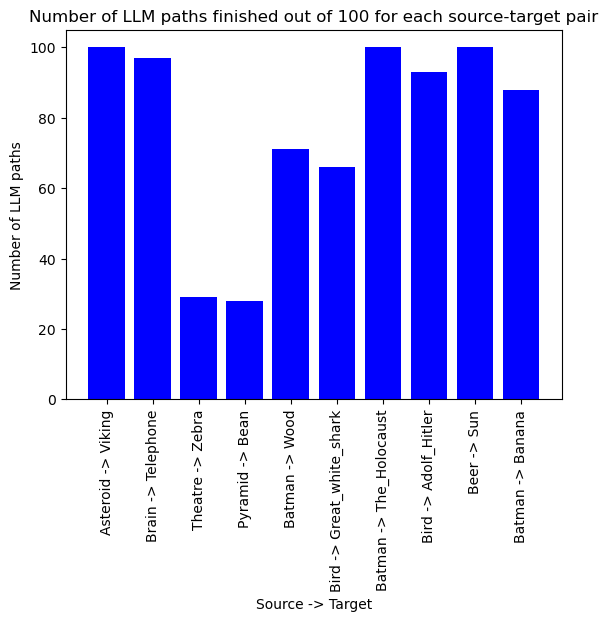

In [90]:
for source, target in zip(sources, targets):
    nb_llm_paths = len(llm_paths[source+"_"+target])    
    plt.bar(f"{source} -> {target}", nb_llm_paths, color='blue')
plt.ylabel("Number of LLM paths")
plt.xlabel("Source -> Target")
plt.title("Number of LLM paths finished out of 100 for each source-target pair")
plt.xticks(rotation=90)
plt.show()

## What is the LLM's strategy?
We studied the LLM strategy to know why they don't get as good performance as real players. We ran page rank algorithm on the graph of links and plotted the average ranks of nodes for the most common path lengths for players and LLMs on each source-target pair. We can see that players tend to go up quickly to a "Hub" and then go down to the target. The LLMs on the other hand don't have a clear pattern in their paths. This confirms to us that they are not good on all tasks and also that they are not very consistent. However, we observed that when they use the "Hub" strategy they are as god as humans (example: Batman -> The Holocaust path).

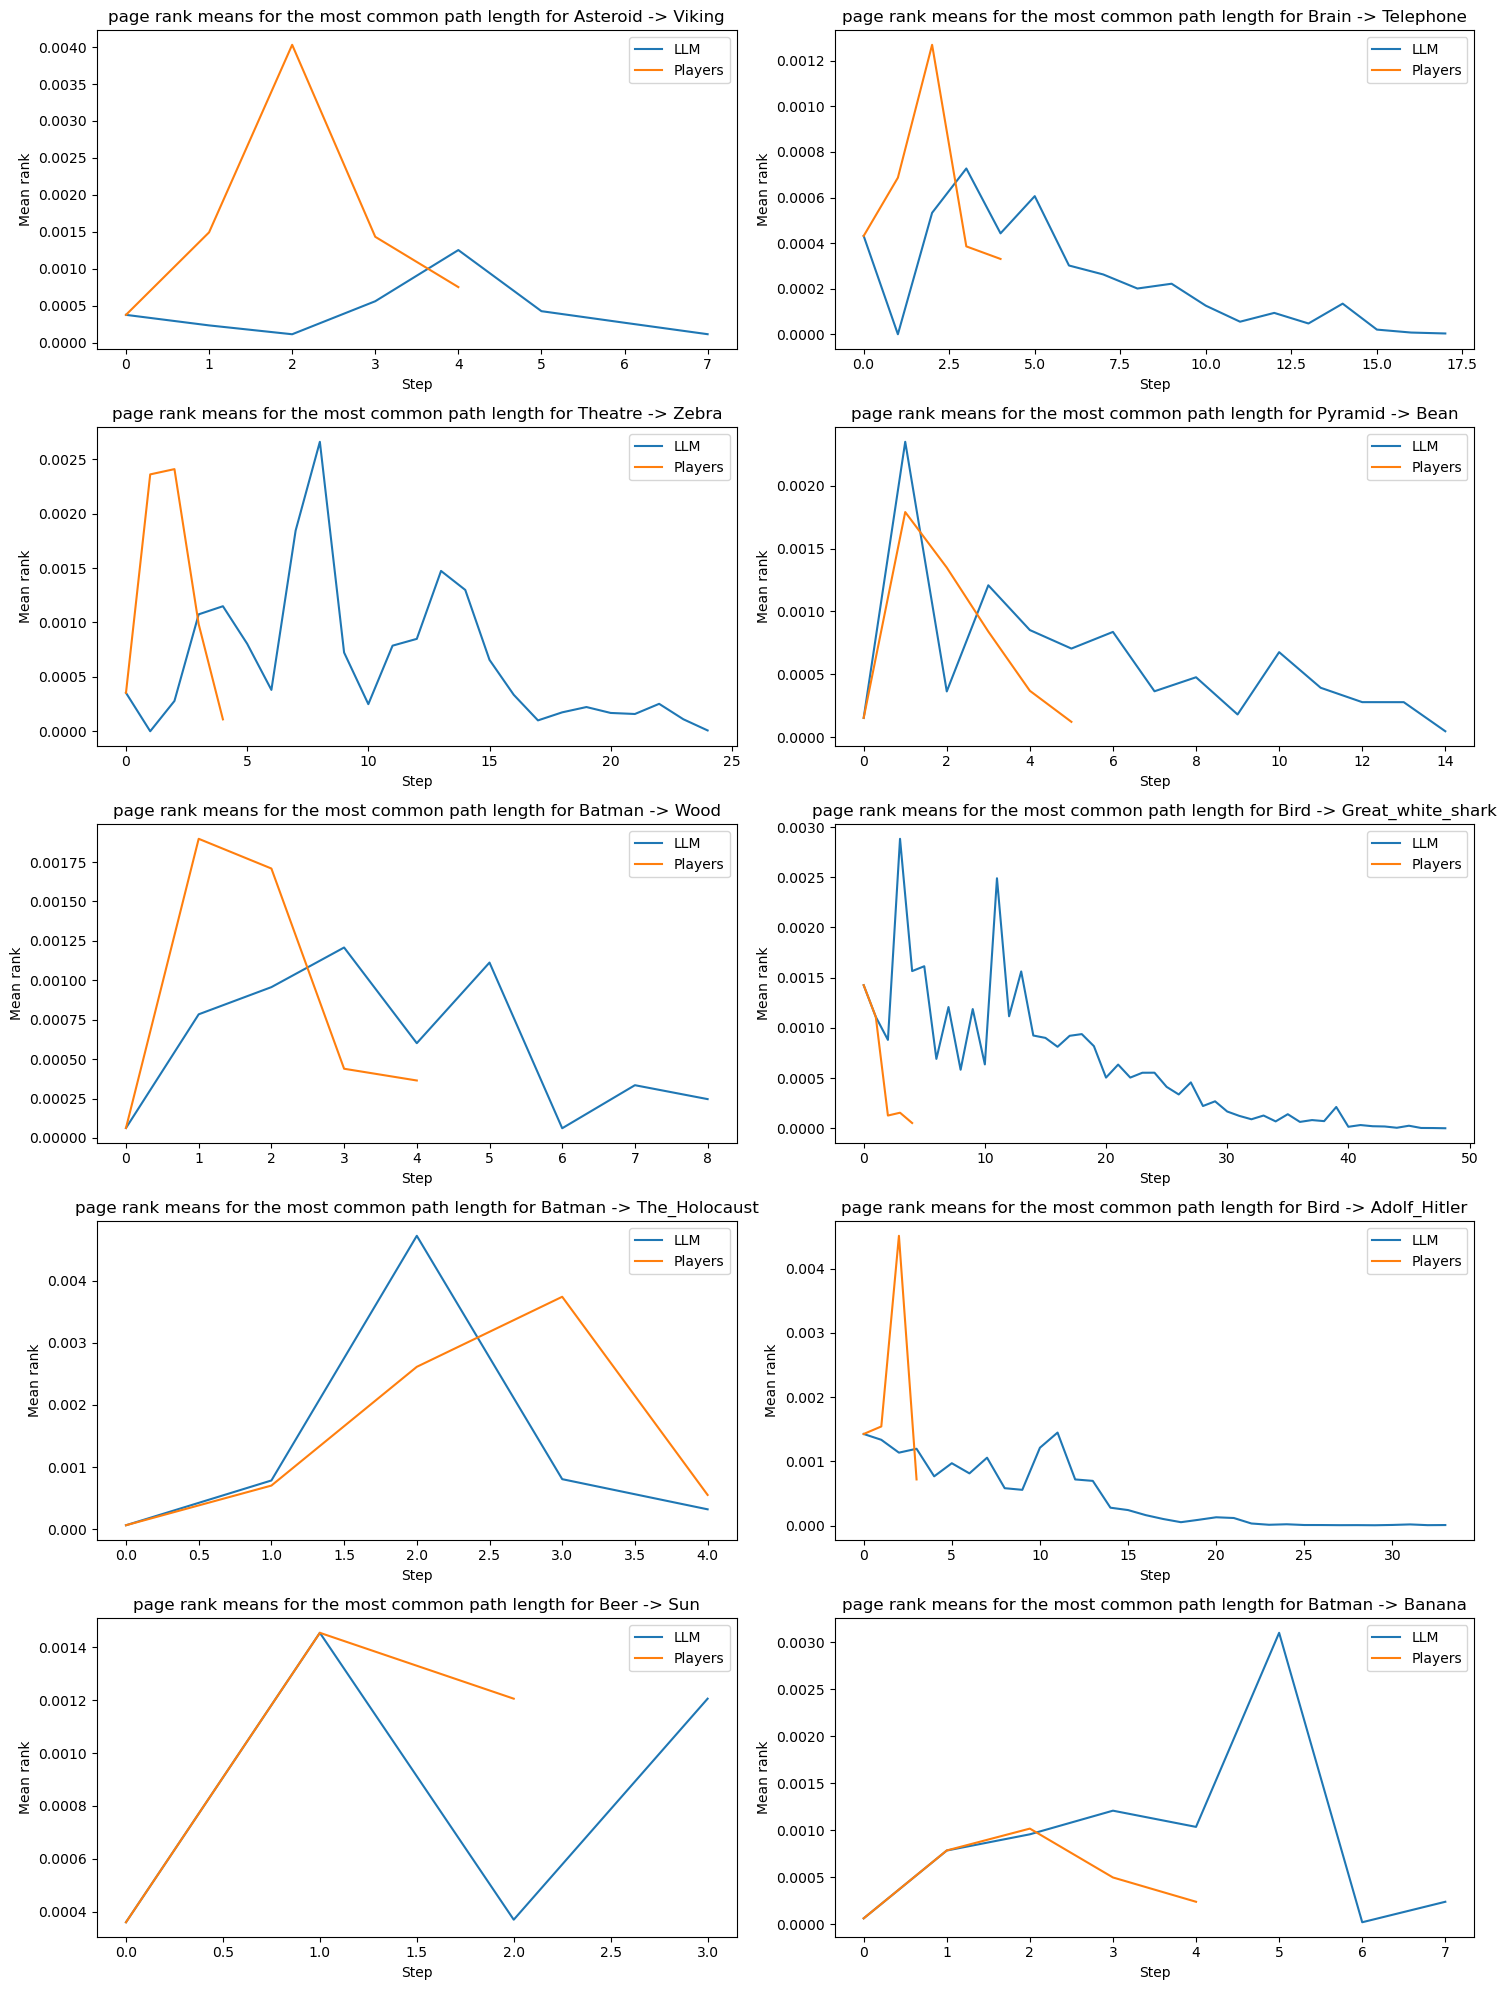

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.flatten()

for idx, (source, target) in enumerate(zip(sources, targets)):
    player_paths = finished_paths_df[(finished_paths_df["source"] == source) & (finished_paths_df["target"] == target)]
    most_common_length = player_paths["path_length"].mode().values[0]
    paths_with_most_common_length = player_paths[player_paths["path_length"] == most_common_length]
    mean_ranks = []
    for i in range(most_common_length+1):
        rank_i = 0
        for path in paths_with_most_common_length["clean_path"]:
            rank_i += ranks[path[i]]
        rank_i /= len(paths_with_most_common_length)
        mean_ranks.append(rank_i)

    llm_paths_source_target = llm_paths[source+"_"+target]
    most_common_llm_path_length = max([len(path) for path in llm_paths_source_target])
    mean_ranks_llm = []
    for i in range(most_common_llm_path_length):
        rank_i = 0
        for path in llm_paths_source_target:
            if len(path) > i:
                if path[i] not in ranks:
                    continue
                rank_i += ranks[path[i]]
        rank_i /= len(llm_paths_source_target)
        mean_ranks_llm.append(rank_i)
    axs[idx].plot(range(most_common_llm_path_length), mean_ranks_llm, label="LLM")
    axs[idx].plot(range(most_common_length+1), mean_ranks, label="Players")
    axs[idx].set_ylabel("Mean rank")
    axs[idx].set_xlabel("Step")
    axs[idx].set_title(f"Page rank means for the most common path length for {source} -> {target}")
    axs[idx].legend()

plt.tight_layout()
plt.show()


## Take away about LLMs
LLMs are a very good tool that could make our lives easier in many ways. However, one should not trust them blindly. They can give us inaccurate or even wrong answers. We can ask them for help and advice but they are still far from human strategic thinking and way of reasoning.

# Links coordinates analysis

We obtained the x and y coordinates of the links by using Selenium. It enables us to open the html file of the articles in a simulated browser and then select the links we are interested in. We set the window size of the browser to 1920x1080 because it is the most common. 
Also, when the next article in path is accessible via several links, we stored the coordinates of all these links.

We run this algorithm on each path of the 50 most popular source-target peers.

The code doing that can be found in the `src/links_coordinates.py` file.
 
The data collected this way is stored in the files `data/links_coordinates_optimal.csv` for the links coordinates of the optimal paths, `data/links_coordinates_finished.csv` for the links coordinates of the finished paths and `data/links_coordinates_unfinished.csv` for the links coordinates of the unfinished paths.

Let's vizualize where people click!

In [4]:
links_coords_optimal = pd.read_csv("data/links_coordinates_optimal.csv")
links_coords_finished = pd.read_csv("data/links_coordinates_finished.csv")
links_coords_unfinished = pd.read_csv("data/links_coordinates_unfinished.csv")

In [ ]:
def plot_coordinates_distribution(links_coords_data, title):
    all_links_coords = []
    for links_coords in links_coords_data["links_coords"].apply(eval).values:
        all_links_coords.extend(links_coords)

    x_coords = [coord[0] for coord in all_links_coords]
    y_coords = [coord[1] for coord in all_links_coords]

    plt.figure(figsize=(10, 8))
    sns.kdeplot(x=x_coords, y=y_coords, fill=True, thresh=0, levels=100, cmap="OrRd")
    plt.xlim(0, 1920)
    plt.ylim(0, 4000)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.show()

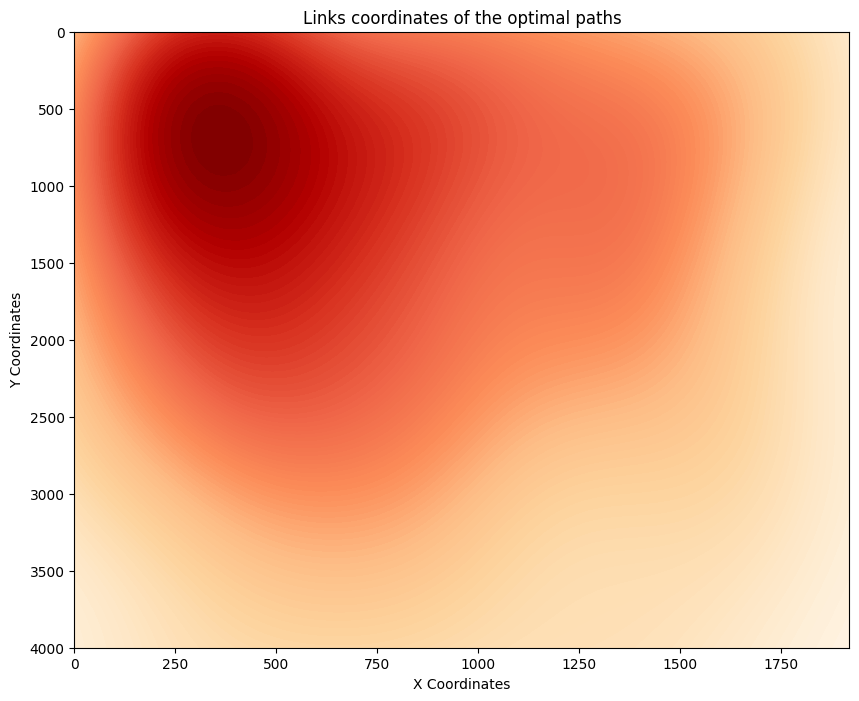

In [21]:
plot_coordinates_distribution(links_coords_optimal, "Links coordinates of the optimal paths")

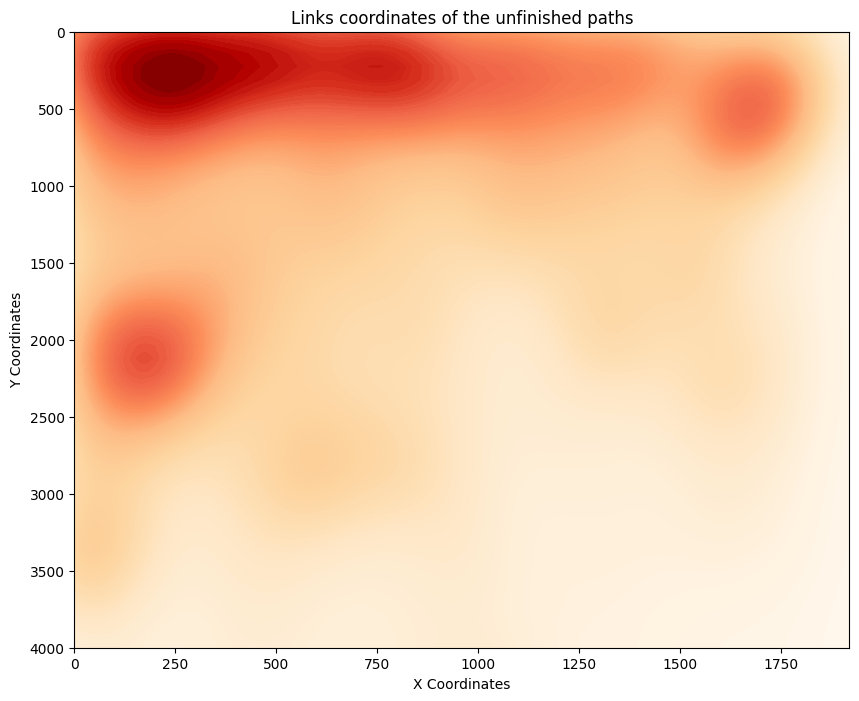

In [7]:
plot_coordinates_distribution(links_coords_unfinished, "Links coordinates of the unfinished paths")

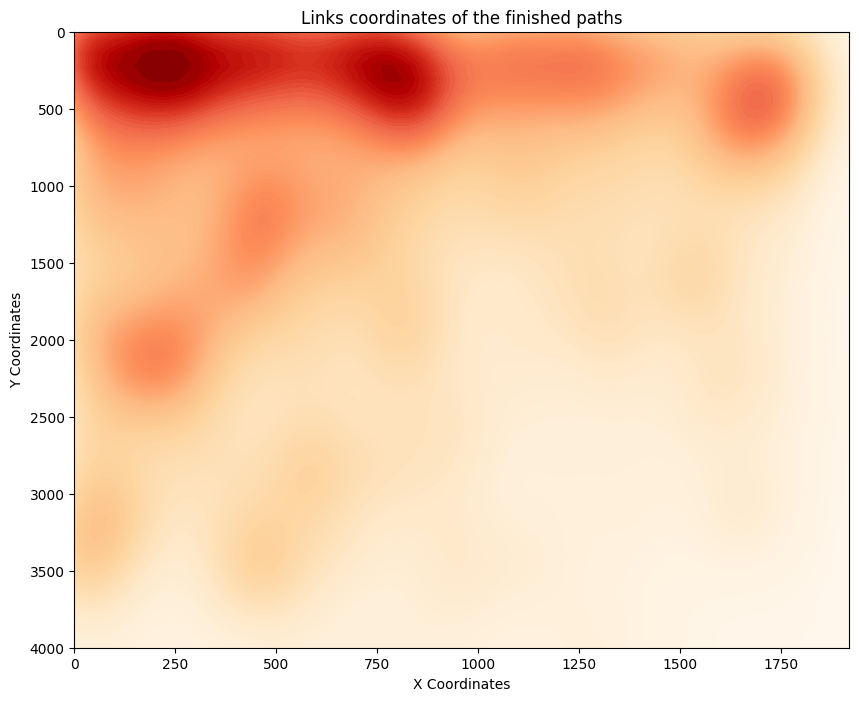

In [8]:
plot_coordinates_distribution(links_coords_finished, "Links coordinates of the finished paths")

Let's plot all of it side by side to compare.

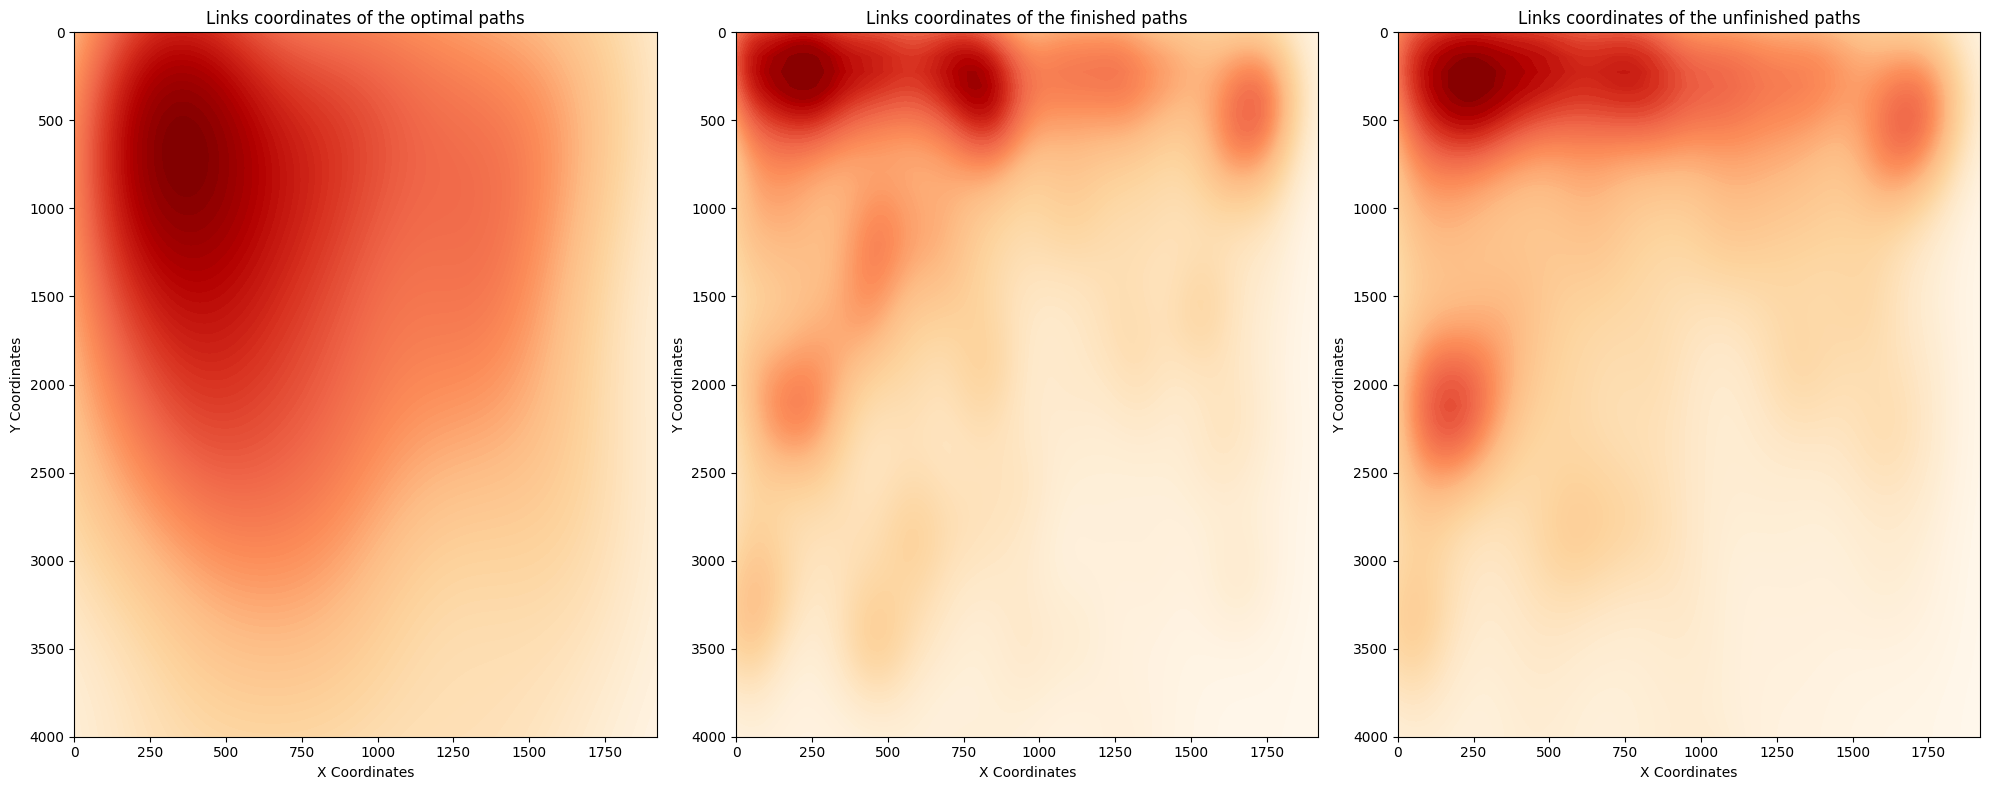

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

def plot_coordinates_distribution(ax, links_coords_data, title):
    all_links_coords = []
    for links_coords in links_coords_data["links_coords"].apply(eval).values:
        all_links_coords.extend(links_coords)

    x_coords = [coord[0] for coord in all_links_coords]
    y_coords = [coord[1] for coord in all_links_coords]

    sns.kdeplot(ax=ax, x=x_coords, y=y_coords, fill=True, thresh=0, levels=100, cmap="OrRd")
    ax.set_xlim(0, 1920)
    ax.set_ylim(0, 4000)
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("X Coordinates")
    ax.set_ylabel("Y Coordinates")

plot_coordinates_distribution(axs[0], links_coords_optimal, "Links coordinates of the optimal paths")
plot_coordinates_distribution(axs[1], links_coords_finished, "Links coordinates of the finished paths")
plot_coordinates_distribution(axs[2], links_coords_unfinished, "Links coordinates of the unfinished paths")

plt.tight_layout()
plt.show()

As we can see, we, as humans, are lazy. Indead most of the links clicked are at the very top of the articles, probably in the first article while the best links can be found at almost any coordinates in the article as we can see in the first plot.

We also observe that almost no links are clicked after 2000 in Y coordinates. For most screen sizes, reaching these coordinates requires scrolling down. This means people most of time do not make the effort to explore the whole article before making a choice.

Comparing the plots, we can see that people who found a path clicked more on links between 1000 and 1500 in Y coordinate than those who didn't find a path. This shows that they are more likely to explore the entire article presented to them.

### What next ?

For further analysis, it will be interesting to see how these variables vary over time, i.e. whether people explore articles more at the start of the path than after several clicks.

It will also be interesting to see the distribution of the position of links chosen by people as a function of their performance, i.e. as a function of path size. Are the best paths obtained more often by exploring more of the article?